In [1]:
import pandas as pd
import pickle
import numpy as np
from collections import Counter
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from scipy.spatial.distance import mahalanobis
from scipy.stats import chi2
from sklearn.covariance import EmpiricalCovariance
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import warnings
from sklearn.exceptions import ConvergenceWarning, UndefinedMetricWarning

warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

In [2]:
with open("../data/antidiabetic/antidiabetic_mordred_descriptors.pkl", "rb") as f:
    df_a = pickle.load(f)

In [3]:
with open("../data/non_antidiabetic/non_antidiabetic_mordred_descriptors.pkl", "rb") as f:
    df_N = pickle.load(f)

In [4]:
df_a['y'] = 1
df_N['y'] = -1

# Merge dataframes
df = pd.concat([df_a, df_N], ignore_index=True)

In [5]:
df

,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,LogEE_A,...,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2,y
0,-1,-1,0,5,12.617971,2.169236,4.338473,12.617971,1.147088,3.228488,...,39.497463,129.101445,6.455072,168,12,44.0,46.0,6.083333,2.777778,1
1,-1,-1,0,0,40.169033,2.454310,4.904372,40.169033,1.295775,4.369201,...,80.653339,444.140673,7.931083,2901,52,166.0,198.0,10.583333,6.777778,1
2,-1,-1,0,0,20.141728,2.358666,4.717332,20.141728,1.184808,3.715821,...,49.119415,276.033541,9.201118,566,22,80.0,88.0,7.395833,3.875000,1
3,-1,-1,1,0,29.731577,2.410924,4.686258,29.731577,1.292677,4.062270,...,71.006770,315.183444,6.566322,1269,32,118.0,136.0,7.027778,5.083333,1
4,-1,-1,0,0,38.878448,2.371316,4.742632,38.878448,1.254143,4.342553,...,66.435015,445.178375,7.675489,3430,44,156.0,176.0,10.340278,6.819444,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2501,-1,-1,0,4,13.384261,2.449490,4.898979,13.384261,1.338426,3.322799,...,41.530657,140.106196,6.368463,96,12,60.0,72.0,1.944444,2.000000,-1
2502,-1,-1,0,0,12.527715,2.230994,4.461989,12.527715,1.252771,3.188912,...,38.855012,137.071488,7.214289,121,11,44.0,48.0,3.722222,2.444444,-1
2503,-1,-1,2,2,42.998757,2.540439,4.933716,42.998757,1.343711,4.416159,...,85.419850,428.232460,7.137208,3125,51,174.0,210.0,8.201389,7.097222,-1
2504,-1,-1,0,0,43.761692,2.346713,4.691132,43.761692,1.215603,4.468152,...,71.787750,540.207627,7.502884,3504,60,174.0,197.0,14.833333,8.166667,-1


In [6]:
print("Distribution of classes before balancing:")
print(Counter(df['y']))

Distribution of classes before balancing:
Counter({-1: 2461, 1: 45})


In [7]:
import pandas as pd

# Assuming your DataFrame is called df
# Filter rows by class
y_1 = df[df['y'] == 1]
y_minus1 = df[df['y'] == -1]

# Exclude non-descriptor columns (e.g., categorical identifiers or target)
exclude_columns = ['y']
descriptor_columns = [col for col in df.columns if col not in exclude_columns]

# Function to calculate frequency of non-zero values per descriptor
def compute_nonzero_frequency(df_subset):
    return (df_subset[descriptor_columns] != 0).sum(axis=0) / len(df_subset)

# Compute frequencies for each class
freq_y1 = compute_nonzero_frequency(y_1)
freq_y_minus1 = compute_nonzero_frequency(y_minus1)

# Combine into a single DataFrame for comparison
freq_comparison = pd.DataFrame({
    'freq_y1': freq_y1,
    'freq_y-1': freq_y_minus1,
    'difference': freq_y1 - freq_y_minus1
}).sort_values(by='difference', ascending=False)

from IPython.display import display
display(freq_comparison[:10])

,freq_y1,freq_y-1,difference
nS,0.533333,0.212922,0.320412
GGI10,0.866667,0.567249,0.299418
JGI10,0.866667,0.567249,0.299418
NssNH,0.622222,0.357985,0.264238
SssNH,0.622222,0.357985,0.264238
n6ARing,0.644444,0.388054,0.256391
NsssCH,0.800000,0.548964,0.251036
SsssCH,0.800000,0.548964,0.251036
nARing,0.822222,0.571312,0.250910
nHBDon,0.977778,0.740349,0.237428


In [9]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency
from statsmodels.stats.multitest import multipletests
from IPython.display import display

# Припускаємо, що ваш DataFrame називається df
# Фільтруємо рядки за класами
y_1 = df[df['y'] == 1]
y_minus1 = df[df['y'] == -1]

# Виключаємо нецільові колонки
exclude_columns = ['y']
descriptor_columns = [col for col in df.columns if col not in exclude_columns]

# Функція для обчислення частоти ненульових значень на дескриптор
def compute_nonzero_frequency(df_subset):
    return (df_subset[descriptor_columns] != 0).sum(axis=0) / len(df_subset)

# Обчислюємо частоти для кожного класу
freq_y1 = compute_nonzero_frequency(y_1)
freq_y_minus1 = compute_nonzero_frequency(y_minus1)

# Додаємо статистичні критерії
chi2_stats, p_values = [], []

for col in descriptor_columns:
    # Контингентна таблиця [[присутні, відсутні] у y=1; те саме для y=-1]
    a = int((y_1[col] != 0).sum())                     # присутнє у y=1
    b = len(y_1) - a                                   # відсутнє у y=1
    c = int((y_minus1[col] != 0).sum())                # присутнє у y=-1
    d = len(y_minus1) - c                              # відсутнє у y=-1
    
    table = np.array([[a, b],
                      [c, d]])
    
    # Перевірка на валідність таблиці
    if np.any(table == 0) or np.sum(table) == 0:
        # Якщо є нулі в таблиці або вся таблиця нульова
        chi2_stats.append(np.nan)
        p_values.append(np.nan)
    elif a == 0 and c == 0:
        # Якщо дескриптор взагалі не присутній в жодному класі
        chi2_stats.append(np.nan)
        p_values.append(np.nan)
    elif b == 0 and d == 0:
        # Якщо дескриптор присутній у всіх зразках обох класів
        chi2_stats.append(np.nan)
        p_values.append(np.nan)
    else:
        try:
            # Перевірка, чи достатньо спостережень для χ²-тесту
            if np.all(table >= 5):
                # Без Yates корекції (correction=False) коли очікувані n≥5
                chi2, p, _, _ = chi2_contingency(table, correction=False)
            else:
                # З Yates корекцією для малих вибірок
                chi2, p, _, _ = chi2_contingency(table, correction=True)
            
            chi2_stats.append(chi2)
            p_values.append(p)
        except (ValueError, ZeroDivisionError):
            # Якщо все ж таки виникає помилка
            chi2_stats.append(np.nan)
            p_values.append(np.nan)

# Корекція множинних перевірок – FDR Benjamini–Hochberg
# Відфільтровуємо NaN значення для корекції
valid_p_values = [p for p in p_values if not np.isnan(p)]
if len(valid_p_values) > 0:
    reject, q_vals, _, _ = multipletests(p_values, method='fdr_bh', 
                                       is_sorted=False, returnsorted=False)
    significant_fdr = reject
else:
    q_vals = [np.nan] * len(p_values)
    significant_fdr = [False] * len(p_values)

# Об'єднуємо в єдиний DataFrame для порівняння
freq_comparison = pd.DataFrame({
    'freq_y1': freq_y1,
    'freq_y-1': freq_y_minus1,
    'difference': freq_y1 - freq_y_minus1,
    'chi2_stat': chi2_stats,
    'p_value': p_values,
    'FDR_q': q_vals,
    'significant_FDR': significant_fdr
})

# Сортуємо за різницею (як в оригінальному коді)
freq_comparison = freq_comparison.sort_values(by='difference', ascending=False)

# Відображення результатів
display(freq_comparison[:10])

# Додаткова інформація
valid_tests = sum(1 for p in p_values if not np.isnan(p))
significant_count = sum(1 for s in significant_fdr if s)

print(f"\nЗагальна кількість дескрипторів: {len(descriptor_columns)}")
print(f"Валідних статистичних тестів: {valid_tests}")
print(f"Значущих після FDR корекції (α=0.05): {significant_count}")
print(f"Розмір груп: y=1 ({len(y_1)}), y=-1 ({len(y_minus1)})")

# Опціонально: збережіть результати
# freq_comparison.to_csv('descriptor_analysis_results.csv', index=True)

,freq_y1,freq_y-1,difference,chi2_stat,p_value,FDR_q,significant_FDR
nS,0.533333,0.212922,0.320412,26.553932,2.562826e-07,NaN,True
GGI10,0.866667,0.567249,0.299418,16.188940,5.732784e-05,NaN,True
JGI10,0.866667,0.567249,0.299418,16.188940,5.732784e-05,NaN,True
NssNH,0.622222,0.357985,0.264238,13.348296,2.586575e-04,NaN,False
SssNH,0.622222,0.357985,0.264238,13.348296,2.586575e-04,NaN,False
n6ARing,0.644444,0.388054,0.256391,12.181488,4.826612e-04,NaN,False
NsssCH,0.800000,0.548964,0.251036,11.268633,7.882776e-04,NaN,False
SsssCH,0.800000,0.548964,0.251036,11.268633,7.882776e-04,NaN,False
nARing,0.822222,0.571312,0.250910,11.390444,7.382287e-04,NaN,False
nHBDon,0.977778,0.740349,0.237428,11.881429,5.669644e-04,NaN,False



Загальна кількість дескрипторів: 1826
Валідних статистичних тестів: 550
Значущих після FDR корекції (α=0.05): 5
Розмір груп: y=1 (45), y=-1 (2461)


In [10]:
freq_comparison.to_csv('../data/antidiabetic/feature_frequency_comparison_Mordred.csv', 
                      index=True, encoding='utf-8')

### 🧪 Split Dataset to Hide Validation Set

At this stage, we prepare the dataset for future training and evaluation:

- `XX`: All features (i.e., all columns **except** the target column `"y"`).
- `yy`: Target labels (class column `"y"`).

We then perform an initial split using `train_test_split`:

- `test_size=0.3`: **30% of the dataset is held out as a validation set** — this subset will be hidden from both training and internal testing.
- `random_state=42`: For reproducibility of the split.
- `stratify=yy`: Ensures class balance in both subsets, which is important for classification tasks.

This validation set (`X_valid`, `y_valid`) will be used later for **final model evaluation** and is not used during model training or hyperparameter tuning.

In [11]:
XX = df.drop(columns="y")
yy = df["y"]
X, X_valid, y, y_valid = train_test_split(XX, yy, test_size=0.3, random_state=42, stratify=yy)

In [12]:
print("Count 1:", (y_valid == 1).sum())
print("Count -1:", (y_valid == -1).sum())
print("All values:")
print(y_valid.value_counts())

Count 1: 14
Count -1: 738
All values:
y
-1    738
 1     14
Name: count, dtype: int64


### ⚖️ Balance the Dataset Using SMOTE

To address class imbalance in the training data, we apply **SMOTE** (Synthetic Minority Over-sampling Technique):

- `SMOTE` creates synthetic examples of the minority class by interpolating between existing samples, rather than duplicating them.
- `random_state=42` ensures reproducibility.

In [13]:
X_for_resampled, X_test, y_for_resampled, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [14]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_for_resampled, y_for_resampled)

df_balanced = pd.concat([pd.DataFrame(X_resampled, columns=X.columns), 
                         pd.Series(y_resampled, name='y')], axis=1)

In [15]:
print("Distribution of classes after balancing:")
print(Counter(df_balanced['y']))

Distribution of classes after balancing:
Counter({-1: 1205, 1: 1205})


In [16]:
X_train = df_balanced.drop(columns="y")
y_train = df_balanced["y"]

### 📊 Check Class Distribution in the Test Set

This code snippet prints the number of samples for each class in the test set `y_test`:

In [17]:
print("Count 1:", (y_test == 1).sum())
print("Count -1:", (y_test == -1).sum())
print("All values:")
print(y_test.value_counts())

Count 1: 9
Count -1: 518
All values:
y
-1    518
 1      9
Name: count, dtype: int64


### 📊 Check Class Distribution in the Training Set

This code outputs the number of samples per class in the training data `y_train`:

In [18]:
print("Count 1:", (y_train == 1).sum())
print("Count -1:", (y_train == -1).sum())
print("All values:")
print(y_train.value_counts())

Count 1: 1205
Count -1: 1205
All values:
y
-1    1205
 1    1205
Name: count, dtype: int64


### 🤖 Define Multiple ML Models and Evaluation Strategy

In this section, we define a diverse set of machine learning models and prepare for model evaluation using cross-validation.

#### 🧠 Models Dictionary

We create a dictionary `models` containing multiple commonly used classification algorithms:

- **Logistic Regression**, including L1 (Lasso), L2 (Ridge), and Elastic Net regularization
- **Naive Bayes**: BernoulliNB and MultinomialNB (with feature scaling)
- **Support Vector Machine**: LinearSVC
- **k-Nearest Neighbors** (k-NN)
- **Tree-based models**: Decision Tree, Random Forest, Gradient Boosting
- **Linear Discriminant Analysis** (LDA)
- **SGD Classifier**: a linear model optimized via stochastic gradient descent

These models cover a variety of approaches (linear, probabilistic, ensemble, and distance-based), allowing for broad comparison.

#### 🔁 Cross-Validation Strategy

We use **Stratified K-Fold Cross-Validation** to ensure that each fold maintains the original class distribution:

### 📏 Evaluation Metrics

We define a set of scoring metrics to comprehensively evaluate model performance:

- **Accuracy** – Overall proportion of correct predictions.
- **Precision** – Correct positive predictions out of all predicted positives.
- **Recall** – Correct positive predictions out of all actual positives.
- **F1-score** – Harmonic mean of precision and recall.
- **ROC AUC** – Area under the Receiver Operating Characteristic curve.
- **Balanced Accuracy** – Average of recall for each class; useful for imbalanced datasets.
- **Matthews Correlation Coefficient (MCC)** – A robust metric that accounts for true/false positives and negatives, especially suitable for binary classification.

In [19]:
# Linear models
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier

# Naive Bayes
from sklearn.naive_bayes import BernoulliNB, MultinomialNB

# Support Vector Machines
from sklearn.svm import LinearSVC

# Nearest Neighbors
from sklearn.neighbors import KNeighborsClassifier

# Tree-based models
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier

# Discriminant Analysis
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Pipelines and preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler

# Model evaluation
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    roc_auc_score, balanced_accuracy_score, matthews_corrcoef, 
    confusion_matrix
)

# Gradient boosting (external)
from xgboost import XGBClassifier

models = {
    'Logistic Regression': LogisticRegression(solver='liblinear'),
    'BernoulliNB' : BernoulliNB(),
    'Multinomial Naive Bayes': make_pipeline(MinMaxScaler(), MultinomialNB()),
    'Linear SVM': LinearSVC(),
    'k-NN': KNeighborsClassifier(),
    'Random Forest': RandomForestClassifier(),
    'LDA': LinearDiscriminantAnalysis(),
    'SGD Classifier': SGDClassifier(),
    'Lasso Regression': LogisticRegression(penalty='l1', solver='saga'),
    'Ridge Regression': RidgeClassifier(alpha=1.0, solver='auto'),
    'Elastic Net': LogisticRegression(penalty='elasticnet', l1_ratio=0.5, solver='saga'),
    'Decision Tree': DecisionTreeClassifier(criterion='gini', max_depth=None),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, learning_rate=0.1),
}

cv = StratifiedKFold(n_splits=12, shuffle=True, random_state=42)

scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1',
    'roc_auc': 'roc_auc',
    'balanced_acc': 'balanced_accuracy',
    'mcc': 'matthews_corrcoef'
}

In [20]:
# Create a DataFrame to store the results
results = []
results_cm = []

# Enumerate models and perform cross-validation and testing
for name, model in models.items():
    print('\n===============================')
    print(f'{name}')
    # Cross-validation
    scores = cross_validate(model, X_train, y_train, cv=cv, scoring=scoring, n_jobs=-1)
    
    # Train the model on the entire training set
    model.fit(X_train, y_train)
    
    # Predictions on the test sample
    y_pred = model.predict(X_test)
    # Check for the presence of the predict_proba or decision_function method
    if hasattr(model, "predict_proba"):
        y_pred_proba = model.predict_proba(X_test)[:, 1]
    elif hasattr(model, "decision_function"):
        y_pred_proba = model.decision_function(X_test)
    else:
        y_pred_proba = None
        y_pred_proba_all = None
    
    # Metrics on the test sample
    test_scores = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'balanced_acc': balanced_accuracy_score(y_test, y_pred), 
        'mcc': matthews_corrcoef(y_test, y_pred)
    }
    # Add ROC AUC metrics if prediction probabilities are available
    if y_pred_proba is not None:
        test_scores['roc_auc'] = roc_auc_score(y_test, y_pred_proba)
    # Saving cross-validation results to a DataFrame
    results.append({
            'Model': name,
            'Data Type': 'Cross-Validation Data',
            'Accuracy': f"{scores['test_accuracy'].mean():.4f} ± {scores['test_accuracy'].std():.4f}",
            'Precision': f"{scores['test_precision'].mean():.4f} ± {scores['test_precision'].std():.4f}",
            'Recall': f"{scores['test_recall'].mean():.4f} ± {scores['test_recall'].std():.4f}",
            'F1 Score': f"{scores['test_f1'].mean():.4f} ± {scores['test_f1'].std():.4f}",
            'ROC AUC': f"{scores['test_roc_auc'].mean():.4f} ± {scores['test_roc_auc'].std():.4f}",
            'balanced_acc': f"{scores['test_balanced_acc'].mean():.4f} ± {scores['test_balanced_acc'].std():.4f}",
            'mcc': f"{scores['test_mcc'].mean():.4f} ± {scores['test_mcc'].std():.4f}",
        })
    
    # Saving test results to DataFrame
    test_scores_row = {
        'Model': name,
        'Data Type': 'Test Data',
        'Accuracy': f"{test_scores['accuracy']:.4f}",
        'Precision': f"{test_scores['precision']:.4f}",
        'Recall': f"{test_scores['recall']:.4f}",
        'F1 Score': f"{test_scores['f1']:.4f}",
        'ROC AUC': f"{test_scores['roc_auc']:.4f}" if 'roc_auc' in test_scores else 'N/A',
        'balanced_acc': f"{test_scores['balanced_acc']:.4f}",
        'mcc': f"{test_scores['mcc']:.4f}",
    }
    results.append(test_scores_row)

    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    cm_result = {
        'Model': name,
        'Data Type': 'Test Data',
    "True Positives (TP)": tp,
    "False Positives (FP)": fp,
    "True Negatives (TN)": tn,
    "False Negatives (FN)": fn
    }
    results_cm.append(cm_result)
    # results_cm.append(cm_result1)
# Convert results to DataFrame
results_df = pd.DataFrame(results)
results_cm = pd.DataFrame(results_cm)


Logistic Regression

BernoulliNB

Multinomial Naive Bayes

Linear SVM

k-NN

Random Forest

LDA

SGD Classifier


/opt/conda/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/conda/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/conda/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/conda/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/conda/lib/python3.13/site-packages/sklearn/linear_model/_stochastic


Lasso Regression


/opt/conda/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnin


Ridge Regression


/opt/conda/lib/python3.13/site-packages/sklearn/linear_model/_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=4.14568e-24): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/conda/lib/python3.13/site-packages/sklearn/linear_model/_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=4.01279e-24): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/conda/lib/python3.13/site-packages/sklearn/linear_model/_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=3.91828e-24): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T



Elastic Net


/opt/conda/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predi


Decision Tree

Gradient Boosting


In [21]:
# Output results
results_df

,Model,Data Type,Accuracy,Precision,Recall,F1 Score,ROC AUC,balanced_acc,mcc
0,Logistic Regression,Cross-Validation Data,0.5257 ± 0.0121,0.5133 ± 0.0066,1.0000 ± 0.0000,0.6783 ± 0.0058,0.6924 ± 0.0390,0.5257 ± 0.0122,0.1581 ± 0.0394
1,Logistic Regression,Test Data,0.0759,0.0181,1.0000,0.0356,0.5506,0.5299,0.0330
2,BernoulliNB,Cross-Validation Data,0.8622 ± 0.0273,0.7867 ± 0.0348,0.9975 ± 0.0043,0.8792 ± 0.0207,0.9614 ± 0.0152,0.8623 ± 0.0273,0.7533 ± 0.0439
3,BernoulliNB,Test Data,0.7362,0.0423,0.6667,0.0795,0.7335,0.7021,0.1180
4,Multinomial Naive Bayes,Cross-Validation Data,0.8992 ± 0.0259,0.8495 ± 0.0370,0.9726 ± 0.0109,0.9065 ± 0.0225,0.9263 ± 0.0272,0.8992 ± 0.0259,0.8078 ± 0.0473
5,Multinomial Naive Bayes,Test Data,0.8235,0.0532,0.5556,0.0971,0.7591,0.6919,0.1299
6,Linear SVM,Cross-Validation Data,0.5270 ± 0.0134,0.5140 ± 0.0072,1.0000 ± 0.0000,0.6789 ± 0.0063,0.6804 ± 0.0364,0.5270 ± 0.0137,0.1613 ± 0.0432
7,Linear SVM,Test Data,0.0759,0.0181,1.0000,0.0356,0.5493,0.5299,0.0330
8,k-NN,Cross-Validation Data,0.9220 ± 0.0206,0.8678 ± 0.0310,0.9975 ± 0.0060,0.9278 ± 0.0176,0.9759 ± 0.0106,0.9220 ± 0.0207,0.8544 ± 0.0360
9,k-NN,Test Data,0.8330,0.0353,0.3333,0.0638,0.6728,0.5875,0.0617


In [22]:
results_df.to_csv('../models/2025_06_10_model_performance_metrics_Mordred.csv', encoding='utf-8')

In [23]:
results_cm

,Model,Data Type,True Positives (TP),False Positives (FP),True Negatives (TN),False Negatives (FN)
0,Logistic Regression,Test Data,9,487,31,0
1,BernoulliNB,Test Data,6,136,382,3
2,Multinomial Naive Bayes,Test Data,5,89,429,4
3,Linear SVM,Test Data,9,487,31,0
4,k-NN,Test Data,3,82,436,6
5,Random Forest,Test Data,1,0,518,8
6,LDA,Test Data,6,64,454,3
7,SGD Classifier,Test Data,6,229,289,3
8,Lasso Regression,Test Data,1,2,516,8
9,Ridge Regression,Test Data,5,20,498,4


In [24]:
results_cm.to_csv('../models/2025_06_10_model_confusion_matrix_summary_Mordred.csv', encoding='utf-8')

In [25]:
with open('../models/2025_06_10_ml_models_mordred.pkl', 'wb') as f:
    pickle.dump(obj=models, file=f)

### 📊 Model Evaluation: Confusion Matrix and Classification Metrics

This section defines two utility functions for evaluating the performance of multiple classification models based on **probability outputs**.

In [26]:
from sklearn.calibration import CalibratedClassifierCV

def calculate_confusion_metrics(y_true, prob_column, threshold=0.5):
    """
    Calculate confusion matrix metrics (TP, FP, TN, FN) for probability predictions
    
    Parameters:
    -----------
    y_true : array-like
        True binary labels
    prob_column : array-like
        Probability predictions from the model
    threshold : float, default=0.5
        Decision threshold for converting probabilities to binary predictions
        
    Returns:
    --------
    dict
        Dictionary containing TP, FP, TN, FN counts
    """
    # Convert probabilities to binary predictions using threshold
    y_pred = np.where(prob_column >= threshold, 1, -1)
    # Calculate confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        # Calculate additional metrics
    # Compute performance metrics and round to 3 decimal places
    accuracy = round(accuracy_score(y_true, y_pred), 3)
    precision = round(precision_score(y_true, y_pred), 3)
    recall = round(recall_score(y_true, y_pred), 3)
    f1 = round(f1_score(y_true, y_pred), 3)
    roc_auc = round(roc_auc_score(y_true, prob_column), 3)
    balanced_acc =  round(balanced_accuracy_score(y_true, y_pred), 3)
    mcc = round(matthews_corrcoef(y_true, y_pred), 3)
    return {
        'True Positives (TP)': tp,
        'False Positives (FP)': fp,
        'True Negatives (TN)': tn,
        'False Negatives (FN)': fn,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'ROC AUC': roc_auc,
        'balanced_acc': balanced_acc,
        'mcc': mcc
    }

def evaluate_models(models, X, y, threshold=0.5):
    """
    Trains models, calibrates where necessary, makes predictions, and calculates evaluation metrics.

    Parameters:
        models (dict): Dictionary of models with names as keys.
        X (array-like): Feature matrix.
        y (array-like): Target labels.
        threshold (float, optional): Threshold for classification. Defaults to 0.5.

    Returns:
        pd.DataFrame: DataFrame with evaluation metrics for each model.
    """
    predictions = {}

    for model_name, model in models.items():
        if isinstance(model, (LinearSVC, SGDClassifier, RidgeClassifier)):
            calibrated = CalibratedClassifierCV(model)
            calibrated.fit(X, y)
            proba = calibrated.predict_proba(X)
        else:
            proba = model.predict_proba(X)
        
        predictions[f'{model_name}_p'] = proba[:, 1]  # Store positive class probabilities

    # Convert predictions to DataFrame
    P_models = pd.DataFrame.from_dict(predictions)

    # Identify probability columns
    prob_columns = [col for col in P_models.columns if col.endswith('_p')]

    # Calculate metrics for each model
    results = []
    for col in prob_columns:
        metrics = calculate_confusion_metrics(y, P_models[col], threshold=threshold)
        metrics['Model'] = col.replace('_p', '')
        results.append(metrics)

    return pd.DataFrame(results).set_index('Model')

In [27]:
metrics = evaluate_models(models, X_valid, y_valid, threshold=0.5)
metrics

/opt/conda/lib/python3.13/site-packages/sklearn/linear_model/_ridge.py:254: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/opt/conda/lib/python3.13/site-packages/sklearn/linear_model/_ridge.py:254: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/opt/conda/lib/python3.13/site-packages/sklearn/linear_model/_ridge.py:254: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/opt/conda/lib/python3.13/site-packages/sklearn/linear_model/_ridge.py:254: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/opt/conda/lib/python3.13/site-packages/sklearn/linear_model/_ridge.py:254: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


,True Positives (TP),False Positives (FP),True Negatives (TN),False Negatives (FN),Accuracy,Precision,Recall,F1 Score,ROC AUC,balanced_acc,mcc
Model,,,,,,,,,,,
Logistic Regression,13,705,33,1,0.061,0.018,0.929,0.036,0.534,0.487,-0.017
BernoulliNB,9,183,555,5,0.750,0.047,0.643,0.087,0.733,0.697,0.122
Multinomial Naive Bayes,5,133,605,9,0.811,0.036,0.357,0.066,0.700,0.588,0.062
Linear SVM,0,0,738,14,0.981,0.000,0.000,0.000,0.875,0.500,0.000
k-NN,9,117,621,5,0.838,0.071,0.643,0.129,0.752,0.742,0.175
Random Forest,6,1,737,8,0.988,0.857,0.429,0.571,0.776,0.714,0.601
LDA,8,93,645,6,0.868,0.079,0.571,0.139,0.749,0.723,0.177
SGD Classifier,0,0,738,14,0.981,0.000,0.000,0.000,0.432,0.500,0.000
Lasso Regression,0,5,733,14,0.975,0.000,0.000,0.000,0.372,0.497,-0.011


In [28]:
metrics.to_csv('../models/2025_06_10_independent_validation_metrics_Mordred.csv', encoding='utf-8')

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
import time

def get_feature_importance(model, X, y, feature_names=None, importance_type='model', 
                           n_repeats=10, random_state=42, n_jobs=-1, top_n=None):
    """
    Calculate and visualize feature importance for a given model.
    
    Parameters:
    -----------
    model : trained model object
        The trained machine learning model.
    X : array-like
        Feature matrix used for training/evaluation.
    y : array-like
        Target vector.
    feature_names : list or None, default=None
        List of feature names. If None, will use column names from X if it's a DataFrame,
        otherwise will generate generic feature names.
    importance_type : str, default='model'
        Type of feature importance to calculate:
        - 'model': Use model's built-in feature_importances_ or coef_ attributes
        - 'permutation': Use permutation importance
        - 'both': Calculate both types
    n_repeats : int, default=10
        Number of times to permute a feature (only used if importance_type='permutation' or 'both')
    random_state : int, default=42
        Random seed for permutation importance
    n_jobs : int, default=-1
        Number of jobs to run in parallel (for permutation importance)
    top_n : int or None, default=None
        If specified, show only top N most important features
        
    Returns:
    --------
    dict
        Dictionary containing feature importance results:
        - 'model_importance': DataFrame with model-based importance if calculated
        - 'permutation_importance': DataFrame with permutation-based importance if calculated
        - 'fig': Matplotlib figure object with the visualization
    """
    # Get feature names if not provided
    if feature_names is None:
        if hasattr(X, 'columns'):
            feature_names = X.columns.tolist()
        else:
            feature_names = [f'Feature {i}' for i in range(X.shape[1])]
    
    results = {}
    
    # Set up the figure and axes for plotting
    fig_height = max(6, min(15, len(feature_names) * 0.3))
    fig, axes = plt.subplots(1, 2 if importance_type == 'both' else 1, 
                             figsize=(15, fig_height), squeeze=False)
    plot_idx = 0
    
    # Calculate model-based importance if requested
    if importance_type in ['model', 'both']:
        model_importance = get_model_feature_importance(model, feature_names)
        
        if model_importance is not None:
            results['model_importance'] = model_importance
            
            # Sort and limit to top N if specified
            importance_df = model_importance.sort_values('Importance', ascending=False)
            if top_n is not None and top_n < len(importance_df):
                importance_df = importance_df.head(top_n)
            
            # Plot model-based importance
            ax = axes[0, plot_idx]
            sns.barplot(x='Importance', y='Feature', data=importance_df, ax=ax,
                      palette="viridis")
            ax.set_title('Model Feature Importance')
            ax.set_xlabel('Importance')
            ax.set_ylabel('Feature')
            ax.grid(axis='x', linestyle='--', alpha=0.6)
            
            plot_idx += 1
    
    # Calculate permutation importance if requested
    if importance_type in ['permutation', 'both']:
        try:
            start_time = time.time()
            perm_importance = permutation_importance(model, X, y, n_repeats=n_repeats,
                                                 random_state=random_state, n_jobs=n_jobs)
            elapsed_time = time.time() - start_time
            print(f"Permutation importance calculation completed in {elapsed_time:.2f} seconds")
            
            # Create DataFrame with permutation importance results
            perm_importance_df = pd.DataFrame({
                'Feature': feature_names,
                'Importance': perm_importance.importances_mean,
                'Std': perm_importance.importances_std
            }).sort_values('Importance', ascending=False)
            
            results['permutation_importance'] = perm_importance_df
            
            # Limit to top N if specified
            if top_n is not None and top_n < len(perm_importance_df):
                perm_importance_df = perm_importance_df.head(top_n)
            
            # Plot permutation importance
            ax = axes[0, plot_idx]
            sns.barplot(x='Importance', y='Feature', data=perm_importance_df, ax=ax,
                      palette="viridis")
            ax.set_title('Permutation Feature Importance')
            ax.set_xlabel('Importance')
            ax.set_ylabel('Feature')
            ax.grid(axis='x', linestyle='--', alpha=0.6)
            
            # Add error bars
            xerr = perm_importance_df['Std'].values
            ax.errorbar(perm_importance_df['Importance'], np.arange(len(perm_importance_df)), 
                      xerr=xerr, fmt='none', ecolor='black', capsize=3)
        except Exception as e:
            print(f"Error calculating permutation importance: {str(e)}")
    
    plt.tight_layout()
    results['fig'] = fig
    
    return results

def get_model_feature_importance(model, feature_names):
    """
    Extract feature importance from model if available.
    
    Parameters:
    -----------
    model : trained model object
        The trained machine learning model.
    feature_names : list
        List of feature names.
        
    Returns:
    --------
    pandas.DataFrame or None
        DataFrame with feature importance if available, None otherwise.
    """
    importance_values = None
    
    # Check if the model has feature_importances_ attribute (tree-based models)
    if hasattr(model, 'feature_importances_'):
        importance_values = model.feature_importances_
    
    # Check if model has coef_ attribute (linear models)
    elif hasattr(model, 'coef_'):
        if len(model.coef_.shape) == 1:
            importance_values = np.abs(model.coef_)  # Take absolute value for linear models
        else:
            # For multi-class, use the mean absolute value across all classes
            importance_values = np.mean(np.abs(model.coef_), axis=0)
    
    # Try to access feature importance through a base_estimator (for meta-estimators)
    elif hasattr(model, 'base_estimator') and hasattr(model.base_estimator, 'feature_importances_'):
        importance_values = model.base_estimator.feature_importances_
    
    # Try to access feature importance through estimator attribute (e.g., for CalibratedClassifierCV)
    elif hasattr(model, 'estimator'):
        # Try with the wrapped estimator
        inner_model = model.estimator
        if hasattr(inner_model, 'feature_importances_'):
            importance_values = inner_model.feature_importances_
        elif hasattr(inner_model, 'coef_'):
            if len(inner_model.coef_.shape) == 1:
                importance_values = np.abs(inner_model.coef_)
            else:
                importance_values = np.mean(np.abs(inner_model.coef_), axis=0)
    
    # If importance values were found, create a DataFrame
    if importance_values is not None:
        # Make sure the length matches
        if len(importance_values) != len(feature_names):
            print(f"Warning: Feature importance length ({len(importance_values)}) doesn't match feature names length ({len(feature_names)})")
            # Try to adjust
            min_len = min(len(importance_values), len(feature_names))
            importance_values = importance_values[:min_len]
            feature_names = feature_names[:min_len]
        
        # Create DataFrame with feature importance
        importance_df = pd.DataFrame({
            'Feature': feature_names,
            'Importance': importance_values
        }).sort_values('Importance', ascending=False)
        
        return importance_df
    else:
        print("Model doesn't have native feature importance. Try using permutation importance instead.")
        return None

def feature_selection_threshold(model, X, y, feature_names=None, step=0.05, 
                               cv=5, scoring='accuracy', verbose=True):
    """
    Find optimal feature selection threshold based on cross-validation performance.
    
    Parameters:
    -----------
    model : model object
        The machine learning model to use.
    X : array-like
        Feature matrix.
    y : array-like
        Target vector.
    feature_names : list or None, default=None
        List of feature names. If None, will use column names from X if it's a DataFrame.
    step : float, default=0.05
        Step size for threshold values to try.
    cv : int, default=5
        Number of cross-validation folds.
    scoring : str, default='accuracy'
        Scoring metric for cross-validation.
    verbose : bool, default=True
        Whether to print progress information.
        
    Returns:
    --------
    dict
        Dictionary containing:
        - 'threshold_results': DataFrame with threshold evaluation results
        - 'best_threshold': Best threshold value
        - 'selected_features': List of selected feature names
        - 'fig': Matplotlib figure object with the visualization
    """
    # Get feature names if not provided
    if feature_names is None:
        if hasattr(X, 'columns'):
            feature_names = X.columns.tolist()
        else:
            feature_names = [f'Feature {i}' for i in range(X.shape[1])]
    
    # Get model feature importance
    importance_df = get_model_feature_importance(model, feature_names)
    
    if importance_df is None:
        print("Cannot perform threshold-based feature selection. Model doesn't provide feature importance.")
        return None
    
    # Try different thresholds
    thresholds = np.arange(0.01, 1.0, step)
    threshold_results = []
    
    for threshold in thresholds:
        # Create feature selector with current threshold
        selector = SelectFromModel(model, threshold=threshold, prefit=False)
        
        # Create pipeline with model
        pipeline = Pipeline([
            ('selector', selector),
            ('model', model)
        ])
        
        # Perform cross-validation
        try:
            scores = cross_val_score(pipeline, X, y, cv=cv, scoring=scoring, n_jobs=-1)
            mean_score = scores.mean()
            std_score = scores.std()
            
            # Fit selector to get selected features count
            selector.fit(X, y)
            selected_mask = selector.get_support()
            n_selected = selected_mask.sum()
            
            # Store results
            threshold_results.append({
                'Threshold': threshold,
                'Mean Score': mean_score,
                'Std Score': std_score,
                'Selected Features': n_selected
            })
            
            if verbose:
                print(f"Threshold: {threshold:.2f}, Score: {mean_score:.4f} ± {std_score:.4f}, Selected: {n_selected}/{len(feature_names)}")
        except Exception as e:
            print(f"Error at threshold {threshold}: {str(e)}")
    
    # Convert to DataFrame
    results_df = pd.DataFrame(threshold_results)
    
    # Find best threshold
    best_idx = results_df['Mean Score'].idxmax()
    best_threshold = results_df.loc[best_idx, 'Threshold']
    best_score = results_df.loc[best_idx, 'Mean Score']
    n_selected = results_df.loc[best_idx, 'Selected Features']
    
    if verbose:
        print(f"\nBest threshold: {best_threshold:.2f} with score {best_score:.4f}, selecting {n_selected} features")
    
    # Get selected features
    selector = SelectFromModel(model, threshold=best_threshold, prefit=False)
    selector.fit(X, y)
    selected_mask = selector.get_support()
    selected_features = [feature_names[i] for i in range(len(feature_names)) if selected_mask[i]]
    
    if verbose:
        print("\nSelected features:")
        for feature in selected_features:
            print(f"- {feature}")
    
    # Plot results
    fig, ax1 = plt.subplots(figsize=(12, 6))
    
    # Plot score
    ax1.set_xlabel('Threshold')
    ax1.set_ylabel('Cross-validation Score', color='tab:blue')
    ax1.plot(results_df['Threshold'], results_df['Mean Score'], 'o-', color='tab:blue')
    ax1.fill_between(results_df['Threshold'], 
                    results_df['Mean Score'] - results_df['Std Score'], 
                    results_df['Mean Score'] + results_df['Std Score'], 
                    alpha=0.2, color='tab:blue')
    ax1.tick_params(axis='y', labelcolor='tab:blue')
    ax1.grid(True, linestyle='--', alpha=0.6)
    
    # Mark best threshold
    ax1.axvline(x=best_threshold, color='r', linestyle='--', alpha=0.7)
    ax1.text(best_threshold + 0.02, best_score, 
            f'Best: {best_threshold:.2f}\nScore: {best_score:.4f}', 
            color='r')
    
    # Plot number of selected features
    ax2 = ax1.twinx()
    ax2.set_ylabel('Number of Selected Features', color='tab:green')
    ax2.plot(results_df['Threshold'], results_df['Selected Features'], 's-', color='tab:green')
    ax2.tick_params(axis='y', labelcolor='tab:green')
    
    plt.title('Feature Selection Threshold Optimization')
    plt.tight_layout()
    
    return {
        'threshold_results': results_df,
        'best_threshold': best_threshold,
        'selected_features': selected_features,
        'fig': fig
    }

def plot_feature_importance_comparison(models_dict, X, y, feature_names=None, 
                                      top_n=10, importance_type='model'):
    """
    Compare feature importance across multiple models.
    
    Parameters:
    -----------
    models_dict : dict
        Dictionary of trained models with model names as keys.
    X : array-like
        Feature matrix used for training/evaluation.
    y : array-like
        Target vector.
    feature_names : list or None, default=None
        List of feature names. If None, will use column names from X if it's a DataFrame.
    top_n : int, default=10
        Number of top features to display.
    importance_type : str, default='model'
        Type of feature importance to use: 'model' or 'permutation'.
        
    Returns:
    --------
    tuple
        (combined_importance_df, fig) containing the combined importance DataFrame and the figure.
    """
    # Get feature names if not provided
    if feature_names is None:
        if hasattr(X, 'columns'):
            feature_names = X.columns.tolist()
        else:
            feature_names = [f'Feature {i}' for i in range(X.shape[1])]
    
    # Dictionary to store importance results for each model
    importance_results = {}
    
    # Calculate importance for each model
    for model_name, model in models_dict.items():
        try:
            # Get feature importance
            if importance_type == 'model':
                importance_df = get_model_feature_importance(model, feature_names)
                if importance_df is None:
                    print(f"Skipping {model_name}: No model-based importance available.")
                    continue
            else:  # permutation importance
                perm_result = get_feature_importance(model, X, y, feature_names=feature_names, 
                                                  importance_type='permutation', n_repeats=5)
                if 'permutation_importance' not in perm_result:
                    print(f"Skipping {model_name}: Error calculating permutation importance.")
                    continue
                importance_df = perm_result['permutation_importance']
            
            # Store the result with model name as key
            importance_df['Model'] = model_name
            importance_results[model_name] = importance_df
        except Exception as e:
            print(f"Error processing {model_name}: {str(e)}")
    
    # Combine all results
    if not importance_results:
        print("No feature importance data available for any model.")
        return None, None
    
    combined_df = pd.concat(importance_results.values(), ignore_index=True)
    
    # Get top N features across all models
    top_features = combined_df.groupby('Feature')['Importance'].mean().nlargest(top_n).index.tolist()
    
    # Filter for those top features
    filtered_df = combined_df[combined_df['Feature'].isin(top_features)]
    
    # Pivot table for heatmap
    pivot_df = filtered_df.pivot(index='Feature', columns='Model', values='Importance')
    
    # Normalize each model's importance (column-wise) to make them comparable
    normalized_pivot = pivot_df.copy()
    for col in normalized_pivot.columns:
        if normalized_pivot[col].sum() > 0:  # Avoid division by zero
            normalized_pivot[col] = normalized_pivot[col] / normalized_pivot[col].sum()
    
    # Plot heatmap
    plt.figure(figsize=(12, 8))
    
    # Mask for missing values
    mask = normalized_pivot.isna()
    
    # Plot heatmap
    ax = sns.heatmap(normalized_pivot, annot=True, cmap="viridis", fmt=".2f", 
                   mask=mask, cbar_kws={'label': 'Normalized Importance'})
    
    plt.title(f'Top {top_n} Feature Importance Comparison Across Models')
    plt.ylabel('Feature')
    plt.xlabel('Model')
    plt.tight_layout()
    
    # Return both DataFrame and figure
    fig = plt.gcf()
    
    return combined_df, fig

/tmp/ipykernel_1493/1920039094.py:78: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, ax=ax,


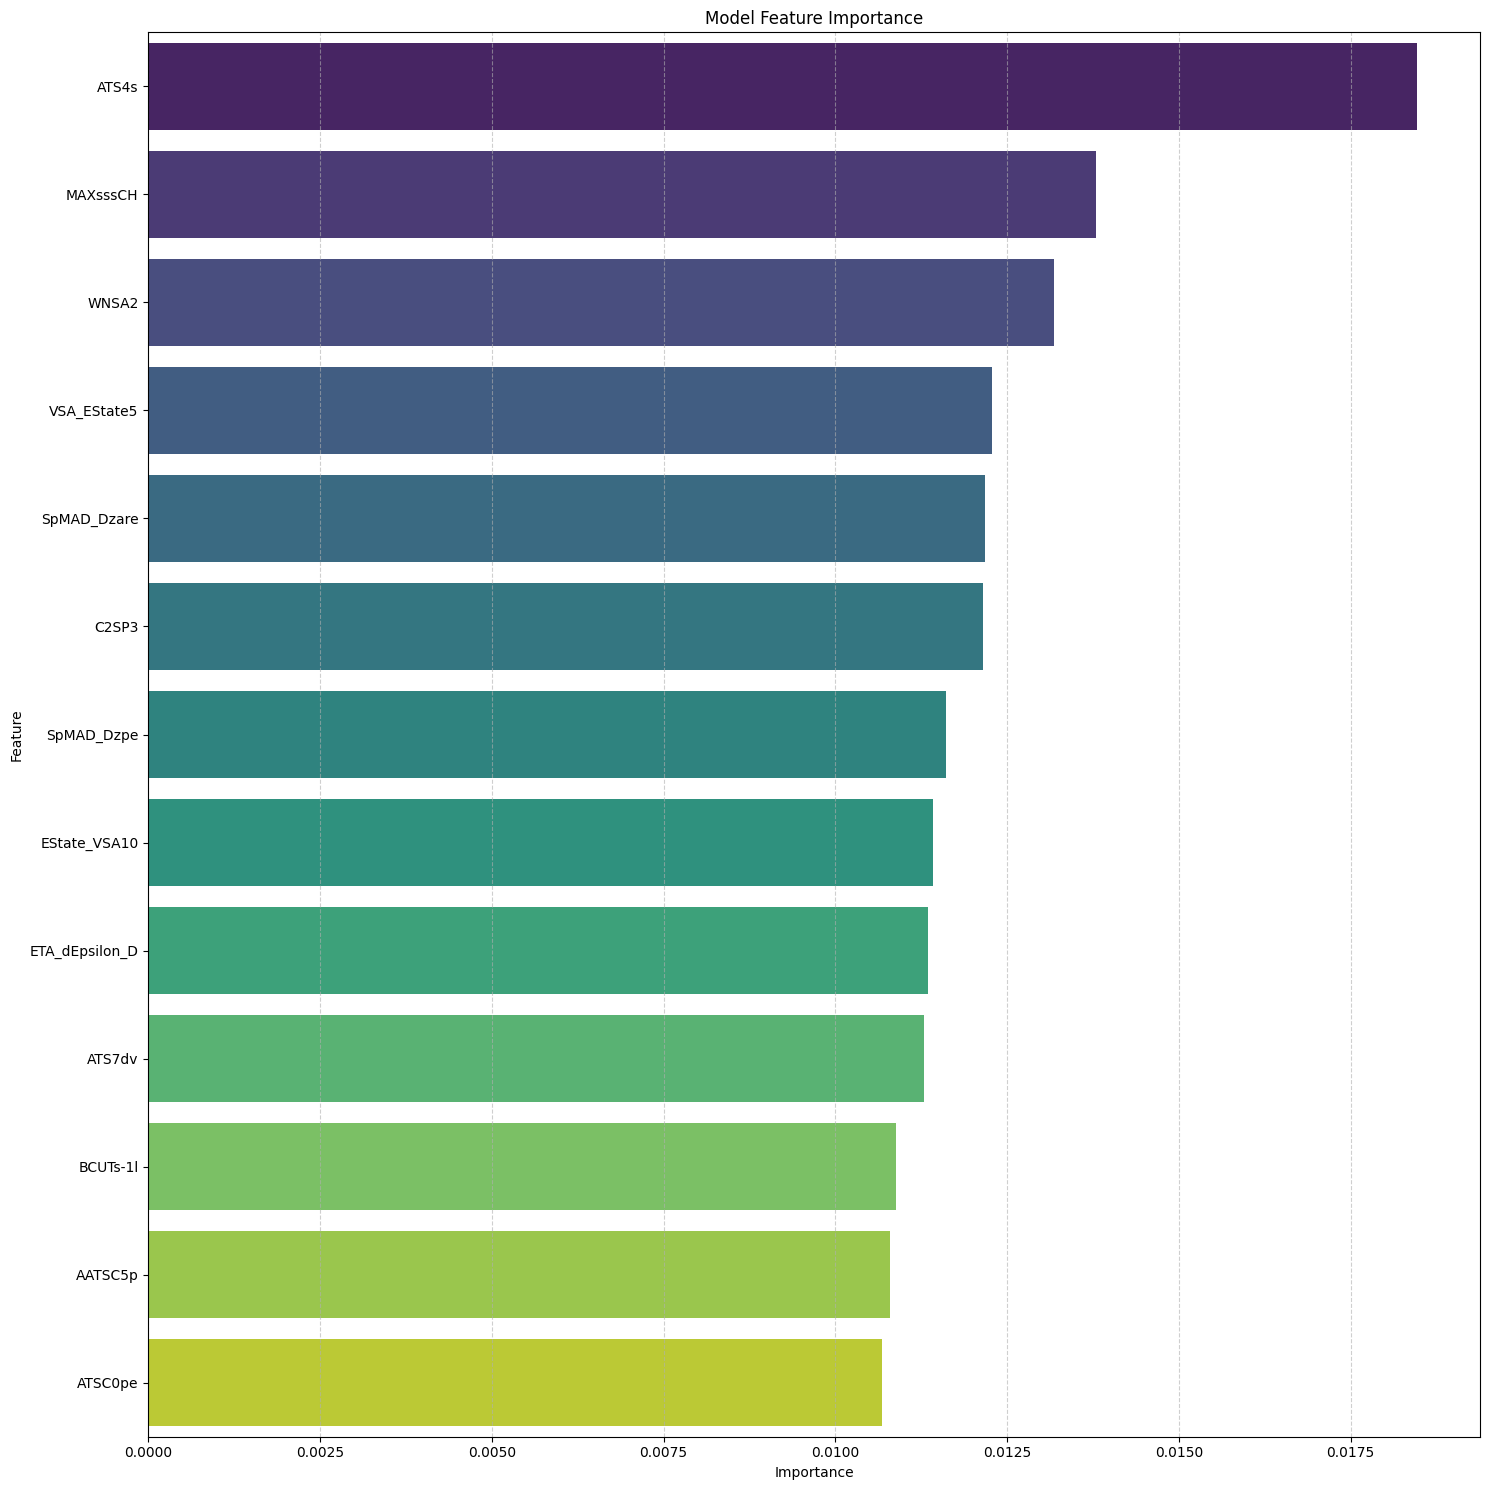

In [30]:
random_forest_importance = get_feature_importance(models['Random Forest'], X, y, feature_names=None, importance_type='model', 
                           n_repeats=10, random_state=42, n_jobs=-1, top_n=13)
random_forest_importance['fig'].savefig('../visuals/2025_06_10_Random Forest_feature_importance_Mordred.png')
random_forest_importance['model_importance'].to_csv('../models/2025_06_10_Random Forest_feature_importance_Mordred.csv')

/tmp/ipykernel_1493/1920039094.py:78: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, ax=ax,


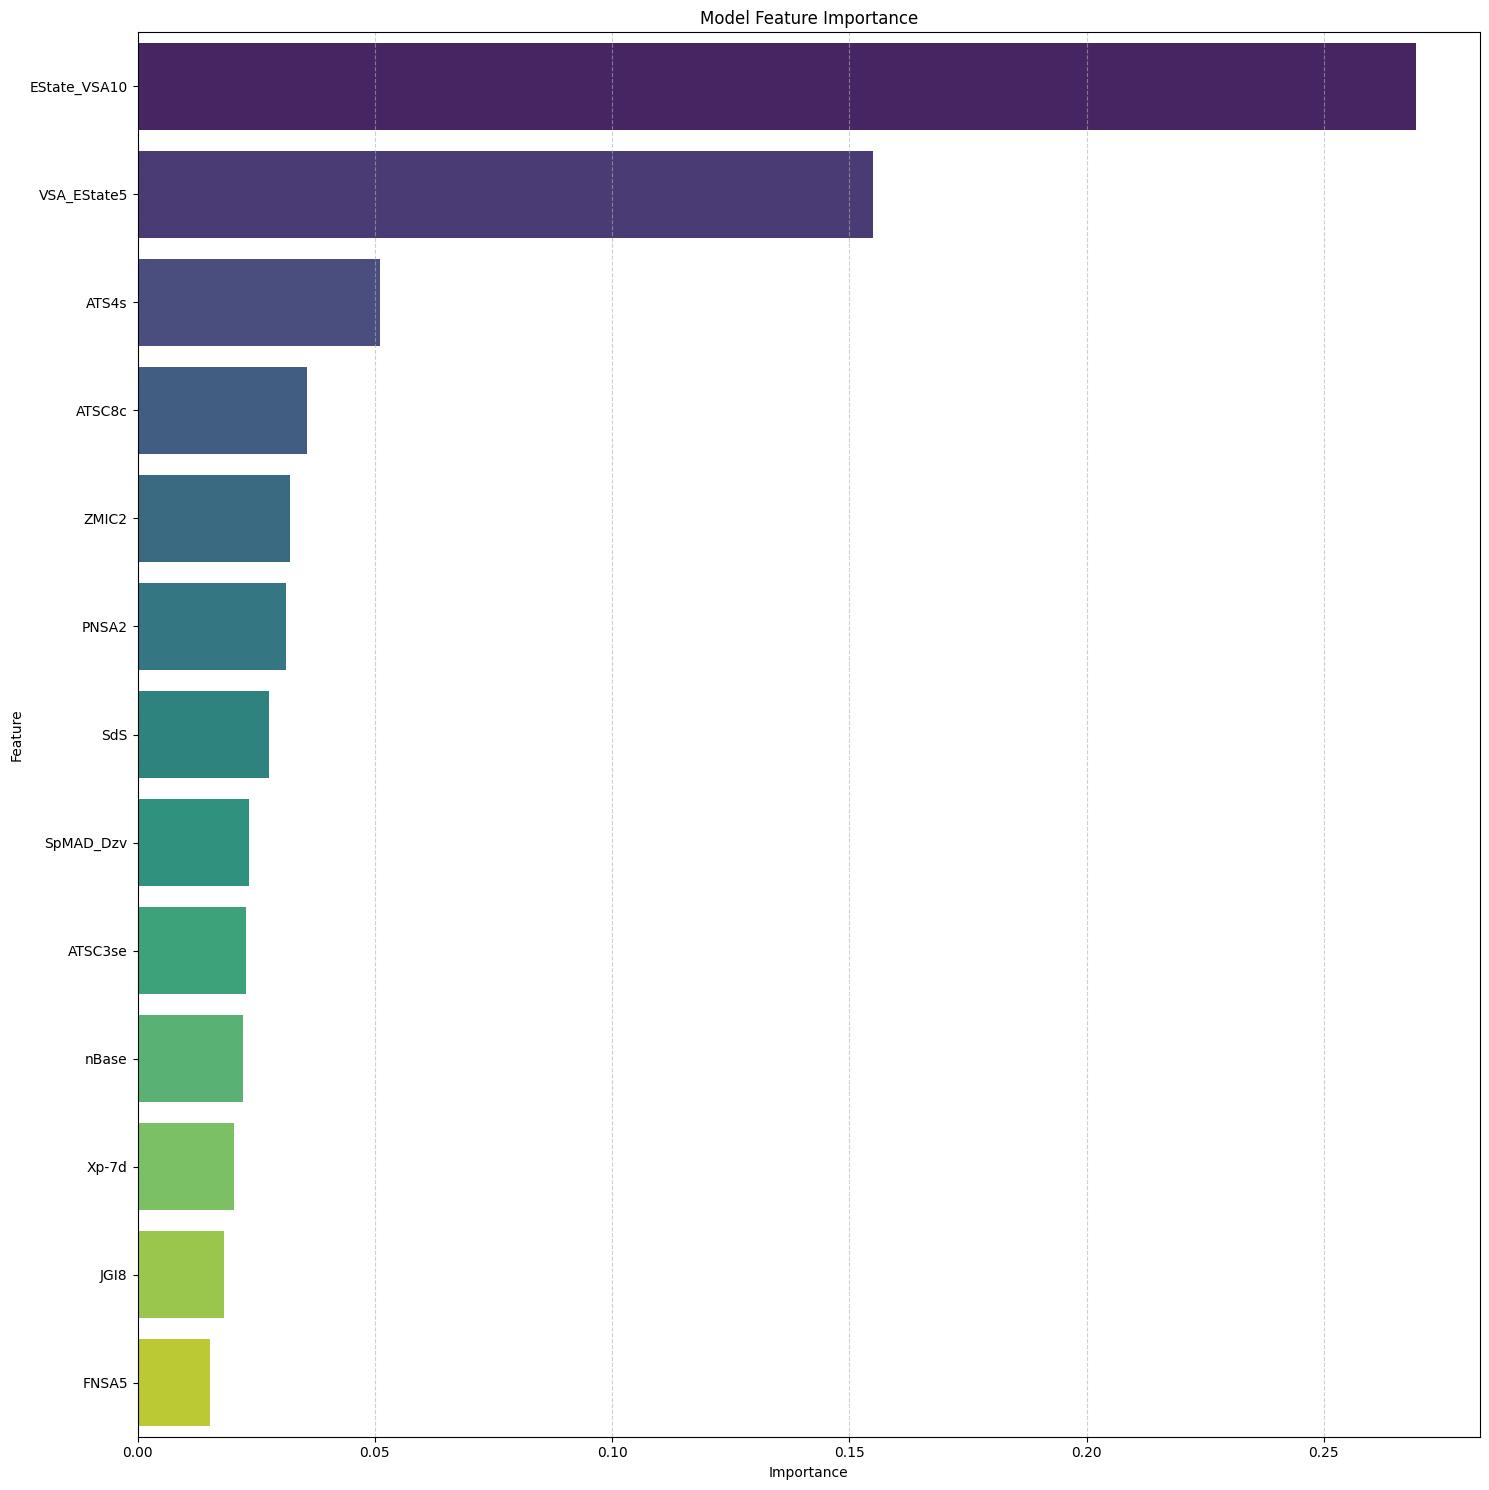

In [31]:
gradient_boosting_importance = get_feature_importance(models['Gradient Boosting'], X, y, feature_names=None, importance_type='model', 
                           n_repeats=10, random_state=42, n_jobs=-1, top_n=13)
gradient_boosting_importance['fig'].savefig('../visuals/2025_06_10_Gradient_Boosting_feature_importance_Mordred.png')
gradient_boosting_importance['model_importance'].to_csv('../models/2025_06_10_Gradient_Boosting_feature_importance_Mordred.csv')

In [32]:
from scipy.spatial.distance import mahalanobis
from scipy.stats import chi2
from sklearn.covariance import EmpiricalCovariance

In [33]:
def compute_mahalanobis_ad(X_train, X_new, alpha=0.95):
    """
    Вычисляет, какие объекты X_new находятся в области применимости по Махаланобису.
    
    Параметры:
        X_train (np.ndarray or pd.DataFrame): обучающие данные
        X_new (np.ndarray or pd.DataFrame): новые объекты (тест/валидация)
        alpha (float): уровень доверия (по умолчанию 95%)

    Возвращает:
        distances: массив расстояний Махаланобиса
        threshold: порог отсечения
        in_ad: булев массив, True — в AD, False — вне AD
    """
    # Убедимся, что входные данные — numpy массивы
    X_train = np.asarray(X_train)
    X_new = np.asarray(X_new)

    # Вычисляем среднее и ковариационную матрицу по обучающему множеству
    mean_vec = np.mean(X_train, axis=0)
    cov_model = EmpiricalCovariance().fit(X_train)
    cov_inv = cov_model.precision_

    # Расстояния Махаланобиса для новых объектов
    distances = np.array([
        mahalanobis(x, mean_vec, cov_inv) for x in X_new
    ])

    # Пороговое значение по распределению хи-квадрат с d степенями свободы
    d = X_train.shape[1]
    threshold = np.sqrt(chi2.ppf(alpha, df=d))

    # Определение области применимости
    in_ad = distances <= threshold

    return distances, threshold, in_ad


In [34]:
# Calculate applicability domain
distances, threshold, in_ad = compute_mahalanobis_ad(X_train, X_valid)

# Output
print("'Applicability Domain (Mahalanobis Distance) by Mordred based models'")
print(f"Cutoff threshold: {threshold:.4f}")
print(f"Number of objects in applicability domain: {np.sum(in_ad)} of {len(in_ad)}")

'Applicability Domain (Mahalanobis Distance) by Mordred based models'
Cutoff threshold: 43.8922
Number of objects in applicability domain: 752 of 752


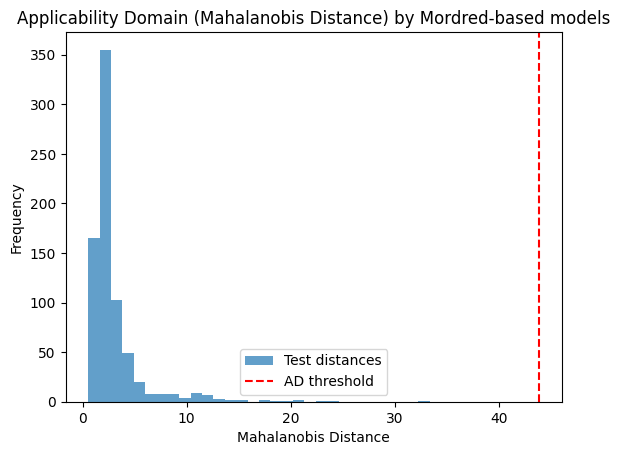

In [35]:
import matplotlib.pyplot as plt

plt.hist(distances, bins=30, alpha=0.7, label='Test distances')
plt.axvline(threshold, color='red', linestyle='--', label='AD threshold')
plt.xlabel('Mahalanobis Distance')
plt.ylabel('Frequency')
plt.title('Applicability Domain (Mahalanobis Distance) by Mordred-based models')
plt.legend()
plt.savefig('../visuals/2025_06_10_Applicability_Domain_(Mahalanobis Distance)_by_Mordred_based_models.png')
plt.show()

In [36]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [37]:
def plot_ad_pca(X_train, X_new, in_ad, title="Applicability Domain (PCA View) by Mordred-based models"):
    """
    Визуализация области применимости с помощью PCA.

    Параметры:
        X_train: обучающие данные (numpy array или DataFrame)
        X_new: новые данные (например, тестовые)
        in_ad: булев массив — какие объекты из X_new находятся в AD
        title: заголовок графика
    """
    pca = PCA(n_components=2)
    X_all = np.vstack([X_train, X_new])
    X_pca = pca.fit_transform(X_all)

    # Отделяем преобразованные точки
    n_train = X_train.shape[0]
    X_train_pca = X_pca[:n_train]
    X_new_pca = X_pca[n_train:]

    # Маскируем по принадлежности к AD
    X_new_in = X_new_pca[in_ad]
    X_new_out = X_new_pca[~in_ad]

    plt.figure(figsize=(8, 6))
    plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], alpha=0.4, label='Training data', c='gray')
    plt.scatter(X_new_in[:, 0], X_new_in[:, 1], alpha=0.8, label='In AD', c='green', marker='o')
    plt.scatter(X_new_out[:, 0], X_new_out[:, 1], alpha=0.8, label='Out of AD', c='red', marker='x')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('../visuals/2025_06_10_Applicability_Domain_PCA_View_by_Mordred_based_models.png')
    plt.show()


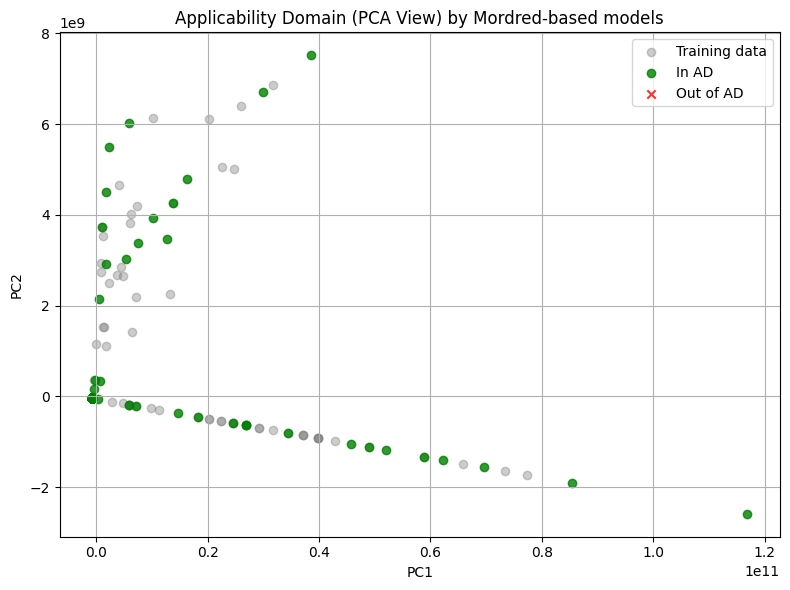

In [38]:
plot_ad_pca(X_train, X_valid, in_ad)